<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_2_Bab_7_7_1_Transfer_Learning_VGG16_untuk_Klasifikasi_Objek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights

from glob import glob
import cv2

from random import shuffle, seed

seed(10)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mengunduh Dataset

In [ ]:
# Google Drive
# https://drive.google.com/file/d/1blLdagaLX7Jx2n3WWgk4yhy2K9Da5ywH/view?usp=sharing

# pip install gdown
!gdown https://drive.google.com/uc?id=1blLdagaLX7Jx2n3WWgk4yhy2K9Da5ywH

Downloading...
From (original): https://drive.google.com/uc?id=1blLdagaLX7Jx2n3WWgk4yhy2K9Da5ywH
From (redirected): https://drive.google.com/uc?id=1blLdagaLX7Jx2n3WWgk4yhy2K9Da5ywH&confirm=t&uuid=96279fb8-b088-4e54-97b3-e5f9c2f1f4c7
To: /content/cat-dog-dataset.zip
100% 229M/229M [00:01<00:00, 137MB/s]


In [ ]:
!unzip -q cat-dog-dataset.zip

In [ ]:
!dir

cat-dog-dataset.zip  sample_data  test_set  training_set


In [ ]:
train_data_dir = 'training_set'
test_data_dir = 'test_set'

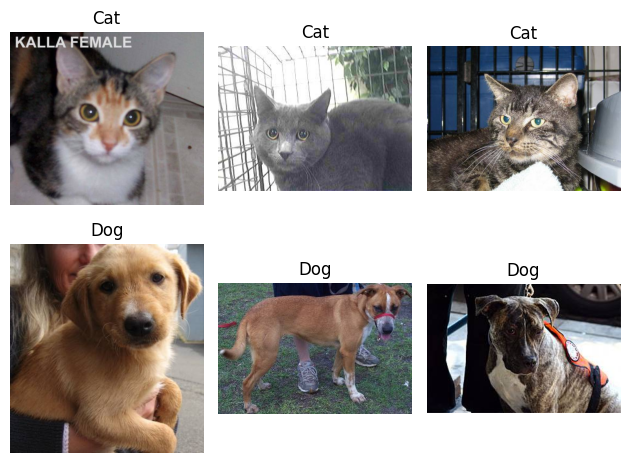

In [ ]:
for i, cat_path in enumerate(glob(f'{train_data_dir}/cats/*.jpg')[:3]):
    img = cv2.imread(cat_path)[:, :, ::-1]  # BGR ke RGB
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Cat')

for i, dog_path in enumerate(glob(f'{train_data_dir}/dogs/*.jpg')[:3]):
    img = cv2.imread(dog_path)[:, :, ::-1]  # BGR ke RGB
    plt.subplot(2, 3, 3 + i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Dog')

plt.tight_layout()
plt.show()

In [ ]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + '/cats/*.jpg')
        dogs = glob(folder + '/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        shuffle(self.fpaths)
        self.targets = [fpath.split("/")[-1].startswith('dog') for fpath in self.fpaths]

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:, :, ::-1])  # BGR ke RGB
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255)
        im = im.permute(2, 0, 1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [ ]:
data = CatsDogs(train_data_dir)

tensor([0.], device='cuda:0')


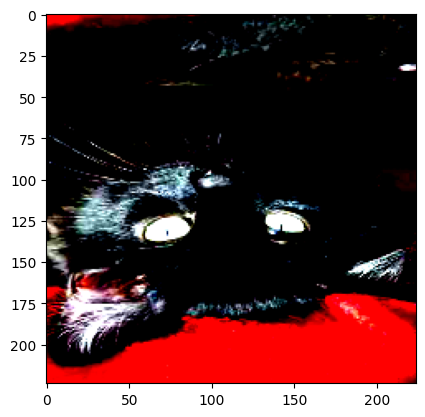

In [ ]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
def get_model():
    model = vgg16(weights=VGG16_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, 1),
                                     nn.Sigmoid())

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return model.to(device), loss_fn, optimizer

In [ ]:
# %pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
        val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(3):
    print(f"Epoch {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []

    for x, y in trn_dl:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x, y in trn_dl:
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for x, y in val_dl:
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epoch 1
Train Loss: 0.5743, Train Accuracy: 0.9708
Validation Loss: 0.4714, Validation Accuracy: 0.9375
Epoch 2
Train Loss: 0.4126, Train Accuracy: 0.9788
Validation Loss: 0.3718, Validation Accuracy: 0.9688
Epoch 3
Train Loss: 0.2882, Train Accuracy: 0.9839
Validation Loss: 0.2435, Validation Accuracy: 1.0000


<ipython-input-18-dc6c64a8ea5d>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


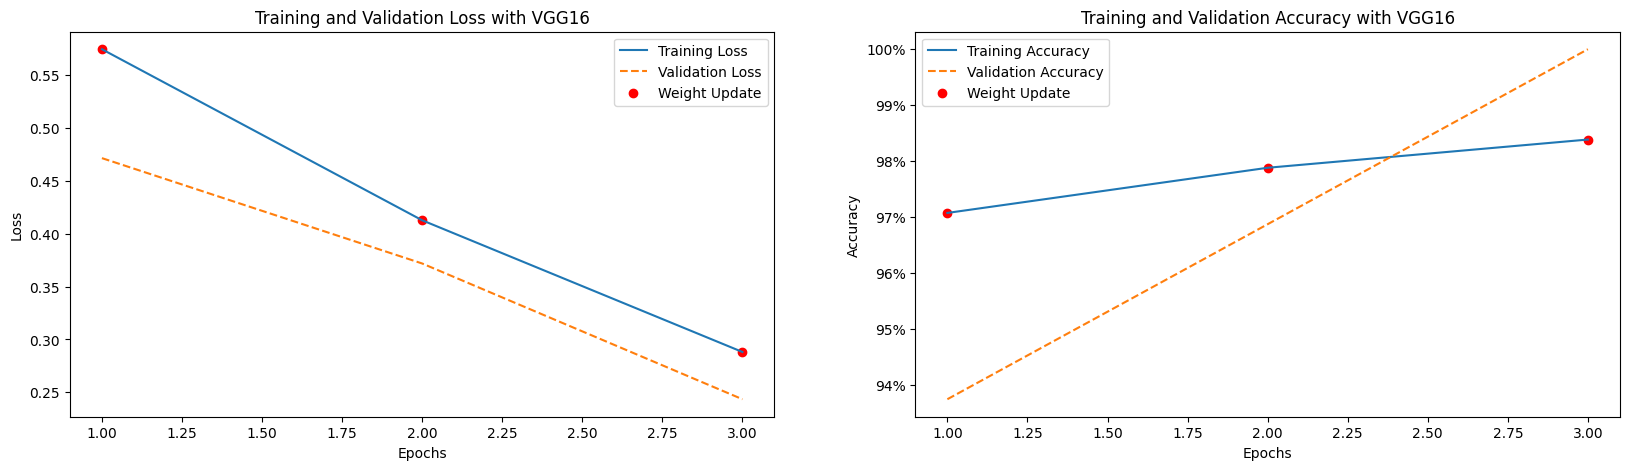

In [ ]:
epochs = np.arange(3) + 1

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.scatter(epochs, train_losses, color='red', label='Weight Update')
plt.title('Training and Validation Loss with VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.scatter(epochs, train_accuracies, color='red', label='Weight Update')
plt.title('Training and Validation Accuracy with VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()

plt.show()